In [1]:
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.pipeline import make_pipeline 
from PIL import Image
from bs4 import BeautifulSoup 
from selenium import webdriver 
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
import time
import networkx as nx 
import pickle
import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

#isntalling all packages needed here 

In [2]:
#dataset is used from - https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls

In [3]:
dataset = pd.read_csv('phishing_site_urls.csv')

In [4]:
dataset.head() #reading first 5 urls from csv

,url,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [5]:
dataset.tail() #last 5

,url,Label
549342,23.227.196.215/,bad
549343,apple-checker.org/,bad
549344,apple-iclods.org/,bad
549345,apple-uptoday.org/,bad
549346,apple-search.info,bad


In [6]:
dataset.info() #infromation about csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549347 entries, 0 to 549346
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     549347 non-null  object
 1   Label   549347 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [7]:
label_counts = pd.DataFrame(dataset.Label.value_counts())

<Axes: xlabel='Label', ylabel='count'>

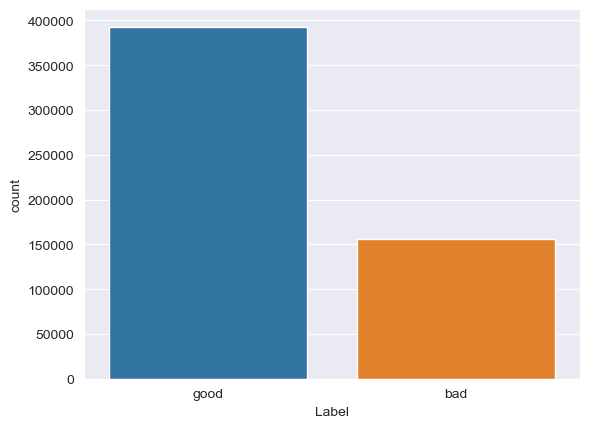

In [8]:
sns.set_style('darkgrid')
sns.barplot(x=label_counts.index, y=label_counts['count'])

In [9]:
#everything before this was just proving dataset exists and 

Preprocessing first step is converting URLs into vector forms, so breaking down the ULR into individual words

In [10]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [11]:
dataset.url[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [12]:
# this will be pull words from the URL
tokenizer.tokenize(dataset.url[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [13]:
#calculating time taken to tokenise words
print('Tokenising Words ...')
t0= time.perf_counter()
dataset['text_tokenized'] = dataset.url.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Tokenising Words ...
Time taken 2.631815300323069 sec


In [14]:
dataset.sample(5) #just testing that the URLS have been vectorised

,url,Label,text_tokenized
121936,imajseslendirme.com/fancybox/drive/,bad,"[imajseslendirme, com, fancybox, drive]"
22096,www.cnhedge.cn/js/index.htm?us.battle.net/logi...,bad,"[www, cnhedge, cn, js, index, htm, us, battle,..."
56895,www.tx.ncsu.edu/jtatm/volume5issue4/Articles/T...,good,"[www, tx, ncsu, edu, jtatm, volume, issue, Art..."
153476,btjunkie.org/torrent/Alias-The-Soundtrack-Best...,good,"[btjunkie, org, torrent, Alias, The, Soundtrac..."
342509,freebase.com/view/en/steve_fuchs,good,"[freebase, com, view, en, steve, fuchs]"


HERE I am using snoballStemmer to get the root word - This process helps in normalizing the URL and reducing its dimensionality, making it easier for machine learning models to analyze and classify malicious URLs effectively.

In [15]:
#Snowball stemmer 
stemmer = PorterStemmer()

In [16]:
print('Getting words stemmed ...')
t0= time.perf_counter()
dataset['text_stemmed'] = dataset['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 62.25297310017049 sec


In [17]:
dataset.sample(5)

,url,Label,text_tokenized,text_stemmed
48702,web.inter.nl.net/hcc/Damburgh_Clun_forest/engl...,good,"[web, inter, nl, net, hcc, Damburgh, Clun, for...","[web, inter, nl, net, hcc, damburgh, clun, for..."
167899,echohillorchards.com/,good,"[echohillorchards, com]","[echohillorchard, com]"
249684,travelingluck.com/North%20America/Canada/Quebe...,good,"[travelingluck, com, North, America, Canada, Q...","[travelingluck, com, north, america, canada, q..."
280913,answers.com/topic/perrault-2,good,"[answers, com, topic, perrault]","[answer, com, topic, perrault]"
110874,konabaridm.edu.bd/BOAMAINFINAL/sitekeyverifica...,bad,"[konabaridm, edu, bd, BOAMAINFINAL, sitekeyver...","[konabaridm, edu, bd, boamainfin, sitekeyverif..."


In [18]:
# here after getting all the root words after being stemmed, I am concatening it all back into a string 

In [19]:
print('Getting joiningwords ...')
t0= time.perf_counter()
dataset['text_sent'] = dataset['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.1922826999798417 sec


In [20]:
dataset.sample(5)

,url,Label,text_tokenized,text_stemmed,text_sent
449610,touring-ohio.com/northeast/akron/akron.html,good,"[touring, ohio, com, northeast, akron, akron, ...","[tour, ohio, com, northeast, akron, akron, html]",tour ohio com northeast akron akron html
434603,southshorecleancities.org/,good,"[southshorecleancities, org]","[southshorecleanc, org]",southshorecleanc org
150756,blog.smalleycreative.com/,good,"[blog, smalleycreative, com]","[blog, smalleycr, com]",blog smalleycr com
342900,freerepublic.com/focus/f-bloggers/2392573/posts,good,"[freerepublic, com, focus, f, bloggers, posts]","[freerepubl, com, focu, f, blogger, post]",freerepubl com focu f blogger post
433479,songkick.com/artists/111215-atrak,good,"[songkick, com, artists, atrak]","[songkick, com, artist, atrak]",songkick com artist atrak


In [21]:
# showing examples of what i have done in a table and the different stages

# Visualization

In [22]:
#sliceing classes and showing pre-processing for 5 good and bad URLS
bad_sites = dataset[dataset.Label == 'bad']
good_sites = dataset[dataset.Label == 'good']

In [23]:
bad_sites.head()

,url,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [24]:
good_sites.head()

,url,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


# Creating the model 

In [25]:
## using the CountVectorizer from scikit-learn to convert text data into numerical feature vectors.

In [26]:
cv = CountVectorizer() 

In [27]:
feature = cv.fit_transform(dataset.text_sent)

In [28]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Spliting the data

In [29]:
trainX, testX, trainY, testY = train_test_split(feature, dataset.Label)

In [30]:
#splitting your dataset into training and testing sets using train_test_split from scikit-learn.

# KNN

In [31]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(trainX, trainY)
print(model)
#this next section is testing the KNN algorithm to check for accuracy scores.

KNeighborsClassifier(n_neighbors=2)


In [30]:
model.score(testX, testY) # this will take about 10 minutes to load

0.9332008125996636

In [32]:
Scores_ml['knn'] = np.round(model.score(testX,testY),2) 
#this will not run due to dataset containing words, therefore it was not an ideal algortihm to use.

NameError: name 'Scores_ml' is not defined

# MultinomialNB

In [ ]:
mnb = MultinomialNB()
#next section is me using MNB to see accuracy scores.

In [ ]:
mnb.score(testX,testY)

In [ ]:
Scores_ml = {}
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

In [ ]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# LogisticRegression

In [ ]:
lr = LogisticRegression()
# this section is testing Logsitic regression to test accuracy scores.

In [ ]:
lr.fit(trainX,trainY)

In [ ]:
lr.score(testX,testY)

Logistic Regression is giving 96% accuracy

In [ ]:
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

In [ ]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# Loading the best model 

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [ ]:
trainX, testX, trainY, testY = train_test_split(dataset.url, dataset.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

In [ ]:
pipeline_ls.score(testX,testY) 

In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

# Testing the model with a URL

In [ ]:
# testing different URLS and prediction scores to test ML model effectivess.

In [ ]:
predict_good = {'www.tec-jo.com/admin_site/upload/files/W2B...'} 
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.predict(predict_good)
prediction_score = loaded_model.predict_proba(predict_good)

print(result)
print("Prediction Score:", prediction_score[0])

In [49]:
#bad # good 